In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=98857ac2a74d9451cb8c8342fd53ed9a471d38ec1e0c39b347bf74a319f9d61f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr
from efficientnet_pytorch import EfficientNet
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_TRANSFORM = A.Compose([
    A.Flip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.3, hue=0, p=0.5),
    A.Blur(blur_limit=4, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

TEST_TRANSFORM = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [5]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = "../input/bfg-dataset/preprocessed_data/" + self.df.loc[idx, "img_id"].replace("\\", "/")

        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            img = self.transform(image=img)["image"]

        return torch.tensor(img.transpose((2, 0, 1))), torch.tensor([self.df.loc[idx, "healthy"]])

    def get_label(self, idx):
        return self.df.loc[idx, "healthy"]

In [6]:
df = pd.read_csv("../input/bfg-dataset/data_additional2.csv")

In [7]:
dataset = {
    "train": MyDataset(df[df["split"] == "train"], transform=TRAIN_TRANSFORM),
    "dev": MyDataset(df[df["split"] == "dev"], transform=TRAIN_TRANSFORM),
    "test": MyDataset(df[df["split"] == "test"], transform=TRAIN_TRANSFORM),
}

In [8]:
dataloader = {
    "train": DataLoader(dataset["train"], batch_size=64, num_workers=2, pin_memory=True),
    "dev": DataLoader(dataset["dev"], batch_size=64, num_workers=2, pin_memory=True),
    "test": DataLoader(dataset["test"], batch_size=64, num_workers=2, pin_memory=True),
}

In [9]:
model = EfficientNet.from_pretrained("efficientnet-b4", num_classes=1).to(DEVICE)
model.load_state_dict(torch.load("../input/bayer-2021-b4-pretrained-v3/best.pth"))
model = model.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
def compute_metrics(split="test"):
    avg_loss = 0

    labels = np.zeros((0, 1))
    preds = np.zeros((0, 1))

    with torch.no_grad():
        for x, y in tqdm(dataloader[split]):
            x = x.to(DEVICE)
            y = y.to(DEVICE, torch.float)

            y_pred = model(x)

            labels = np.concatenate((labels, y.cpu().detach().numpy()))
            preds = np.concatenate((preds, torch.sigmoid(y_pred).cpu().detach().numpy()))

            loss = criterion(y_pred, y)
            avg_loss += loss.item() / len(dataloader[split])

    f1_micro = f1_score(labels, preds > 0.5, average="micro")
    f1_macro = f1_score(labels, preds > 0.5, average="macro")

    return avg_loss, f1_micro, f1_macro

In [12]:
compute_metrics("dev")

  0%|          | 0/256 [00:00<?, ?it/s]

(0.00798113118406718, 0.9977953334558148, 0.9969138112474938)

In [13]:
compute_metrics("test")

  0%|          | 0/256 [00:00<?, ?it/s]

(0.008618711808367152, 0.9976116112437994, 0.9966563224402499)

In [14]:
!curl -o test1.jpg "https://tomathouse.com/wp-content/uploads/2018/09/bakterialnaya-pyatnistost-listya-2.jpg"
!curl -o test2.jpg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzp7wrXvX4dJPdvElmAnuGVc3ekuadpmsQEg&usqp=CAU"
!curl -o test3.jpg "https://www.backyardworkshop.com/wp-content/uploads/2017/02/Brown-Spots-on-Tomato-Leaves.jpg"
!curl -o test4.jpg "https://cdn8.dissolve.com/p/D869_27_632/D869_27_632_1200.jpg"
!curl -o test5.jpg "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F37%2F2020%2F04%2F22%2Fseptoria-spot-tomato-plant-ea2ab44d.jpg"
!curl -o test6.jpg "https://www.tomatogrowing.co.uk/newsletter/wp-content/uploads/2013/02/NewGrowth.jpg"
!curl -o test7.jpg "https://images.wagwalkingweb.com/media/articles/cat/tomato-plant-poisoning/tomato-plant-poisoning.jpg"
!curl -o test8.jpg "https://gardenerspath.com/wp-content/uploads/2019/12/Close-Up-of-Lemons.jpg"
!curl -o test9.jpg "https://gardenerspath.com/wp-content/uploads/2020/09/How-to-Eradicate-Sooty-Mold-From-Your-Plants-Cover.jpg"
!curl -o test10.jpg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKKJfk2Iiz3zyMdQYnqfBiuEl0cA-cZQfO8Q&usqp=CAU"
!curl -o test11.jpg "http://extension.msstate.edu/sites/default/files/publication-images/P3175/Fig._8.jpg"
!curl -o test12.jpg "https://www.nature-and-garden.com/wp-content/uploads/sites/4/2019/08/septoria.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115k  100  115k    0     0   157k      0 --:--:-- --:--:-- --:--:--  157k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7628  100  7628    0     0   413k      0 --:--:-- --:--:-- --:--:--  413k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79278    0 79278    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  110k  100  110k    0     0   220k      0 --:--:-- --:--:-- --:--:--  220k
  % Total    % Received % Xferd  Average Speed   Tim

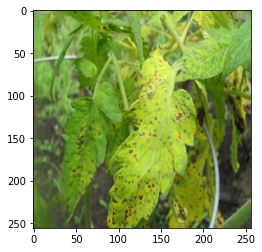

0.0019330205395817757 0.00233518797904253


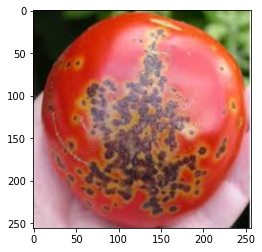

0.0022486322559416294 0.00046736220247112215


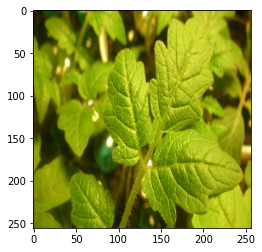

0.9720484614372253 0.9933397173881531


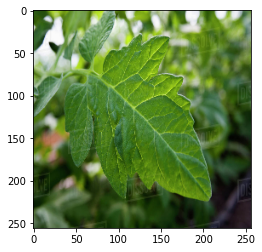

0.9999281167984009 0.9996777772903442


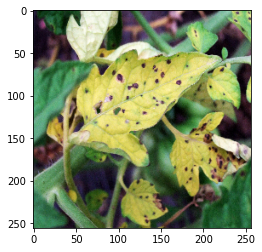

0.13707807660102844 0.058230798691511154


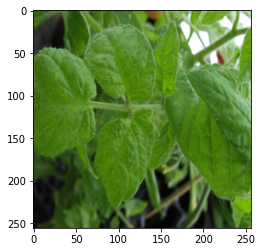

0.9993708729743958 0.9995134472846985


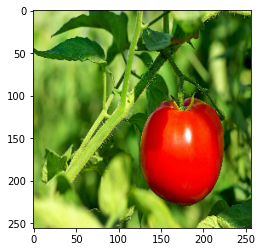

0.9994623064994812 0.9993419647216797


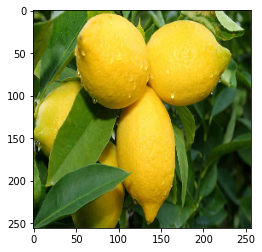

0.999679684638977 0.9994667172431946


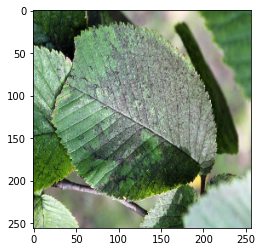

0.9995949864387512 0.998711884021759


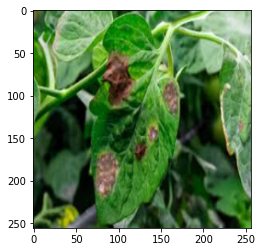

0.0001811942202039063 0.00024145962379407138


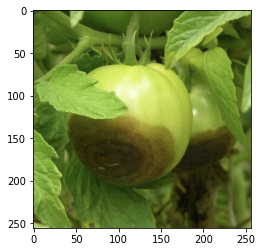

0.9994876384735107 0.9993489384651184


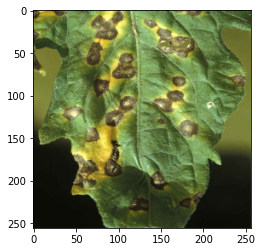

0.4626772105693817 0.13145983219146729


In [15]:
for i in range(1, 13):
    img = cv2.imread("test" + str(i) + ".jpg")
    img = cv2.resize(img, (256, 256))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()

    img_tta_0 = TEST_TRANSFORM(image=img)["image"]
    img_tta_1 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_2 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_3 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_4 = TRAIN_TRANSFORM(image=img)["image"]
    img_tta_5 = TRAIN_TRANSFORM(image=img)["image"]

    with torch.no_grad():
        y_pred_0 = torch.sigmoid(model(torch.tensor([img_tta_0.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        y_pred_1 = torch.sigmoid(model(torch.tensor([img_tta_1.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        y_pred_2 = torch.sigmoid(model(torch.tensor([img_tta_2.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        y_pred_3 = torch.sigmoid(model(torch.tensor([img_tta_3.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        y_pred_4 = torch.sigmoid(model(torch.tensor([img_tta_4.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()
        y_pred_5 = torch.sigmoid(model(torch.tensor([img_tta_5.transpose((2, 0, 1))]).to(DEVICE))).cpu().detach()

    y_pred = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5) / 5

    print(y_pred_0.item(), y_pred.item())